In [1]:
# cell 1 — setup, installs & reproducibility
# If you're in Colab and get errors, uncomment:
# !pip install -q tensorflow matplotlib scikit-learn

import os, random, numpy as np
import tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-09-06 23:45:53.426896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 23:45:53.435658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757180753.445346   36125 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757180753.448198   36125 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757180753.455907   36125 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow: 2.19.0
GPU available: True


In [2]:
# cell 2 (UPDATED) — imports
# Add t-SNE and (optionally) UMAP imports

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # NEW

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models


# UMAP (pip install umap-learn) — we import lazily later to avoid failing if not installed.


In [3]:
# cell 3 — load MNIST dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# small subset to keep runtime low
NUM_TRAIN, NUM_TEST = 15000, 2000
images_all = np.concatenate([train_images[:NUM_TRAIN], test_images[:NUM_TEST]], axis=0)
labels_all = np.concatenate([train_labels[:NUM_TRAIN], test_labels[:NUM_TEST]], axis=0)

print("Raw dataset shapes:", images_all.shape, labels_all.shape)

Raw dataset shapes: (17000, 28, 28) (17000,)


In [4]:
# cell 4 — preprocessing: grayscale → RGB, resize → 32x32, VGG16 normalization

# scale to [0,1] → RGB → resize → MobileNetV2 preprocess
images_all = images_all.astype("float32") / 255.0
images_all = np.expand_dims(images_all, -1)
images_all = np.repeat(images_all, 3, axis=-1)
images_all = tf.image.resize(images_all, (32, 32)).numpy()
images_all = preprocess_input(images_all * 255.0)  # MobileNetV2-specific


print("Preprocessed shape:", images_all.shape, "dtype:", images_all.dtype)

Preprocessed shape: (17000, 32, 32, 3) dtype: float32


I0000 00:00:1757180755.356582   36125 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6083 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# cell 5 — shuffle and split (80/20 train/validation)
      
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(images_all,labels_all,test_size=0.15,shuffle=True,random_state=42)

images_train = X_train
images_val = X_test

labels_train = y_train
labels_val = y_test

print(images_val.shape)
print(labels_val.shape)

(2550, 32, 32, 3)
(2550,)


In [6]:
# cell 6 — build VGG16 backbone (ImageNet weights)

mobilenet_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",            # global average → fixed-length vector
    input_shape=(32, 32, 3),
    alpha=1.0                 # you can reduce (0.75/0.5) to make it even smaller
)
mobilenet_base.trainable = False

mobilenet_base.summary()

/tmp/ipykernel_36125/818011231.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# CANNOT RUN WITH 15% DATA. SO REDUCED to 15000, 2000

In [7]:
# cell 7 — BEFORE transfer: extract features and PCA

features_before = mobilenet_base.predict(images_val, batch_size=16, verbose=1)
pca_before = PCA(n_components=2, random_state=SEED).fit_transform(features_before)

I0000 00:00:1757180757.016355   36227 service.cc:152] XLA service 0x7b79ec001e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757180757.016371   36227 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-09-06 23:45:57.034600: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757180757.279230   36227 cuda_dnn.cc:529] Loaded cuDNN version 90300


 93/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1757180759.099701   36227 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

KeyboardInterrupt: 

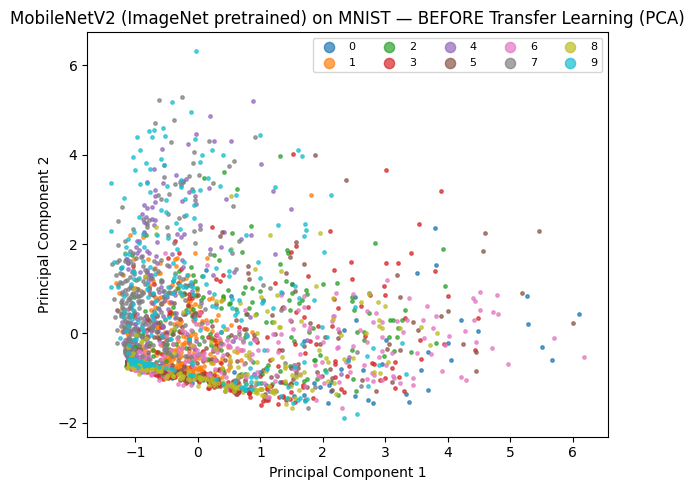

In [ ]:
def plot_pca_scatter(points_2d, labels, title, xlabel, ylabel):
    plt.figure(figsize=(6,5))
    for digit in range(10):
        mask = labels == digit
        plt.scatter(points_2d[mask,0], points_2d[mask,1], 
                    s=6, alpha=0.7, label=str(digit))
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(markerscale=3, fontsize=8, ncol=5)
    plt.tight_layout()
    plt.show()

plot_pca_scatter(pca_before, labels_val,
    "MobileNetV2 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (PCA)",
    "Principal Component 1",
    "Principal Component 2")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2550 samples in 0.001s...
[t-SNE] Computed neighbors for 2550 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2550
[t-SNE] Computed conditional probabilities for sample 2000 / 2550
[t-SNE] Computed conditional probabilities for sample 2550 / 2550
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.639465
[t-SNE] KL divergence after 1000 iterations: 1.148034


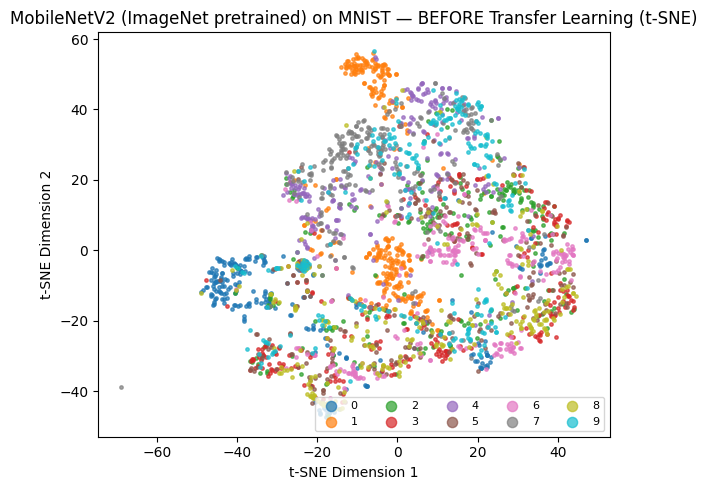

In [ ]:
# cell 7a — BEFORE transfer: t-SNE (2D)

# Tip: t-SNE works best on a few thousand points; our ~1.6k val set is fine.
tsne_before = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=30,          # if you plot only 100 points, reduce to ~15
    max_iter=1000,
    random_state=SEED,
    verbose=1
).fit_transform(features_before)


# plot all or a subset (e.g., first 100)
plot_pca_scatter(tsne_before, labels_val,
    "MobileNetV2 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (t-SNE)",
    "t-SNE Dimension 1",
    "t-SNE Dimension 2")
# or: plot_pca_scatter(tsne_before[:100], labels_val[:100], "... (t-SNE, first 100)")


/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Sep  6 21:44:54 2025 Construct fuzzy simplicial set
Sat Sep  6 21:44:56 2025 Finding Nearest Neighbors
Sat Sep  6 21:44:58 2025 Finished Nearest Neighbor Search
Sat Sep  6 21:44:59 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Sep  6 21:45:01 2025 Finished embedding


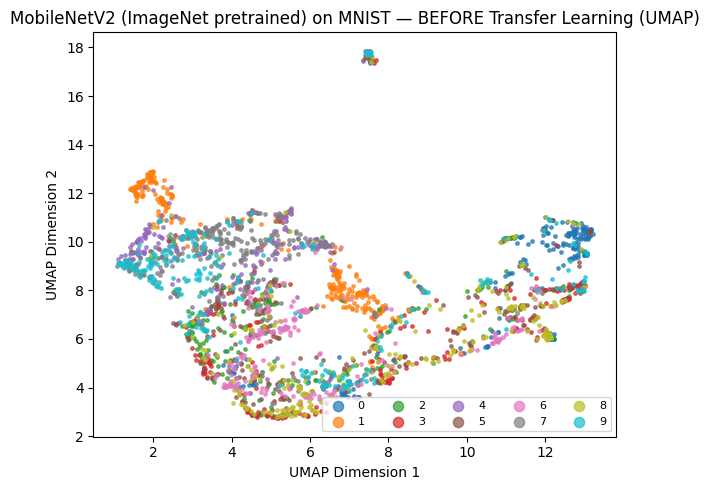

In [ ]:
# cell 7b — BEFORE transfer: UMAP (2D)

import umap  # requires: pip install umap-learn

umap_before = umap.UMAP(
    n_components=2,
    n_neighbors=15,     # local structure; try 10–50
    min_dist=0.1,       # tighter (0.0–0.5)
    metric="euclidean",
    random_state=SEED,
    verbose=True
).fit_transform(features_before)

plot_pca_scatter(umap_before, labels_val,
    "MobileNetV2 (ImageNet pretrained) on MNIST — BEFORE Transfer Learning (UMAP)",
    "UMAP Dimension 1",
    "UMAP Dimension 2")

# or: plot_pca_scatter(umap_before[:100], labels_val[:100], "... (UMAP, first 100)")


In [ ]:
# Unfreeze only the last MobileNetV2 block(s)
for layer in mobilenet_base.layers:
    name = layer.name or ""
    layer.trainable = (name.startswith("block_16") or name.startswith("Conv_1") or name.startswith("out_relu"))

# Add a tiny classifier head
input_layer   = layers.Input(shape=(32, 32, 3))
feature_vec   = mobilenet_base(input_layer, training=True)
output_layer  = layers.Dense(10, activation="softmax")(feature_vec)
transfer_model = models.Model(input_layer, output_layer)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = transfer_model.fit(
    images_train, labels_train,
    epochs=5,                 # bump to 3–5 if you have time
    batch_size=64,
    validation_data=(images_val, labels_val),
    verbose=1
)
print("Validation accuracy after transfer:", history.history["val_accuracy"][-1])

Epoch 1/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7557 - loss: 0.7901 - val_accuracy: 0.1647 - val_loss: 2.2059
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9145 - loss: 0.2805 - val_accuracy: 0.2553 - val_loss: 2.1100
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9652 - loss: 0.1432 - val_accuracy: 0.3596 - val_loss: 2.0052
Epoch 4/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0756 - val_accuracy: 0.4631 - val_loss: 1.8683
Epoch 5/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0405 - val_accuracy: 0.5431 - val_loss: 1.7106
Validation accuracy after transfer: 0.54313725233078


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step


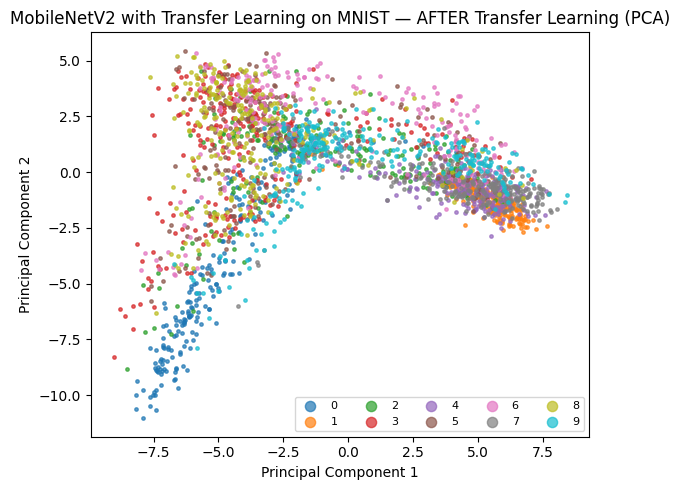

In [ ]:
features_after = mobilenet_base.predict(images_val, batch_size=128, verbose=1)
pca_after = PCA(n_components=2, random_state=SEED).fit_transform(features_after)

plot_pca_scatter(
    pca_after, labels_val,
    "MobileNetV2 with Transfer Learning on MNIST — AFTER Transfer Learning (PCA)",
    "Principal Component 1", "Principal Component 2"
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2550 samples in 0.001s...
[t-SNE] Computed neighbors for 2550 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2550
[t-SNE] Computed conditional probabilities for sample 2000 / 2550
[t-SNE] Computed conditional probabilities for sample 2550 / 2550
[t-SNE] Mean sigma: 2.690773
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.633377
[t-SNE] KL divergence after 1000 iterations: 1.248043


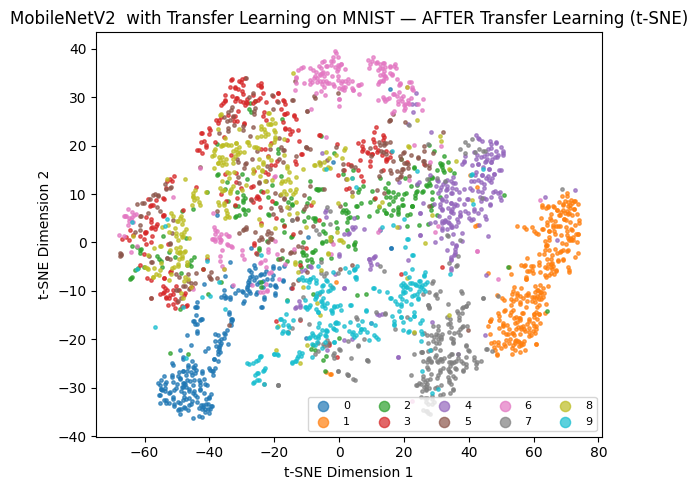

In [ ]:
# cell 9a — AFTER transfer: t-SNE (2D)

tsne_after = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=30,       # if plotting first 100 only, use ~15
    max_iter=1000,
    random_state=SEED,
    verbose=1
).fit_transform(features_after)

plot_pca_scatter(tsne_after, labels_val,
    "MobileNetV2  with Transfer Learning on MNIST — AFTER Transfer Learning (t-SNE)",
    "t-SNE Dimension 1",
    "t-SNE Dimension 2")

# or: plot_pca_scatter(tsne_after[:100], labels_val[:100], "... (t-SNE, first 100)")


/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Sep  6 21:45:28 2025 Construct fuzzy simplicial set
Sat Sep  6 21:45:30 2025 Finding Nearest Neighbors
Sat Sep  6 21:45:31 2025 Finished Nearest Neighbor Search
Sat Sep  6 21:45:31 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Sep  6 21:45:33 2025 Finished embedding


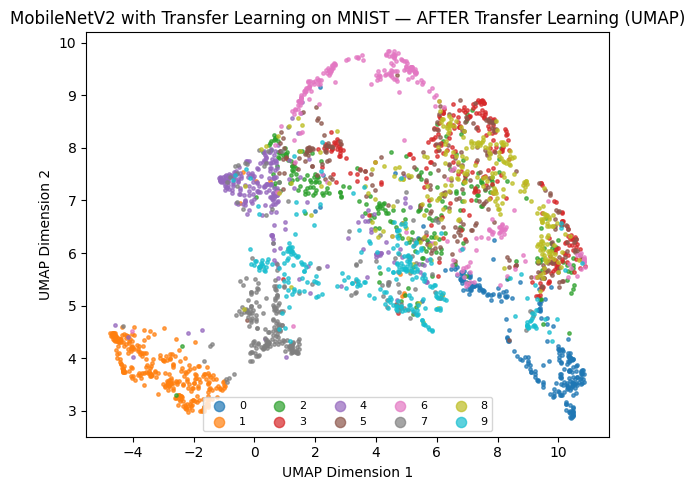

In [ ]:
# cell 9b — AFTER transfer: UMAP (2D)

umap_after = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=SEED,
    verbose=True
).fit_transform(features_after)

plot_pca_scatter(umap_after, labels_val,
    "MobileNetV2 with Transfer Learning on MNIST — AFTER Transfer Learning (UMAP)",
    "UMAP Dimension 1",
    "UMAP Dimension 2")

# or: plot_pca_scatter(umap_after[:100], labels_val[:100], "... (UMAP, first 100)")


In [ ]:
# cell 10 — optional quantitative cluster measure

def mean_within_class_variance(points_2d, labels):
    variances = []
    for digit in range(10):
        class_points = points_2d[labels == digit]
        if len(class_points) > 1:
            variances.append(np.mean(np.var(class_points, axis=0)))
    return float(np.mean(variances)) if variances else np.nan

print("Within-class variance (lower = tighter clusters)")

print("  BEFORE with PCA:", mean_within_class_variance(pca_before, labels_val))
print("  AFTER with PCA :", mean_within_class_variance(pca_after,  labels_val))

print("  BEFORE with TSNE:", mean_within_class_variance(tsne_before, labels_val))
print("  AFTER with TSNE :", mean_within_class_variance(tsne_after,  labels_val))

print("  BEFORE with UMAP:", mean_within_class_variance(umap_before, labels_val))
print("  AFTER with UMAP :", mean_within_class_variance(umap_after,  labels_val))


Within-class variance (lower = tighter clusters)
  BEFORE with PCA: 1.2842634916305542
  AFTER with PCA : 6.970513820648193
  BEFORE with TSNE: 398.2855224609375
  AFTER with TSNE : 279.49127197265625
  BEFORE with UMAP: 6.980313301086426
  AFTER with UMAP : 3.2826476097106934
